In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import accuracy_score

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

# process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

Loaded the dataset with 118 features and 3064705 curves..


In [3]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df[df['sha'] == 9].shape[0]
# df_balanced = df[df['sha'] == 1].sample(len_4) 
df_balanced = df[df['sha'] == 4].iloc[:len_9]
df_balanced = pd.concat([df_balanced, df[df['sha'] == 9]])
df_balanced.sha.value_counts()

# rename 4 to 0 and 9 to 1
df_balanced['sha'] = df_balanced['sha'].replace({4: 0, 9: 1})

In [4]:
# choose model parameters
hidden_units = [128,64,32]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 118 and the output dimension is 2.
Device: cpu.
The model has 26,082 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=118, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [5]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 3
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/3, Training accuracy_score: 0.8283013567332639, Validation accuracy_score: 0.8320856675425116
Epoch 2/3, Training accuracy_score: 0.8292598284666105, Validation accuracy_score: 0.8316890585494026
Epoch 3/3, Training accuracy_score: 0.8343992200023136, Validation accuracy_score: 0.8374894650736205
Save the model from epoch 2 with accuracy_score 0.8374894650736205 to ..\trained_models\model.pth


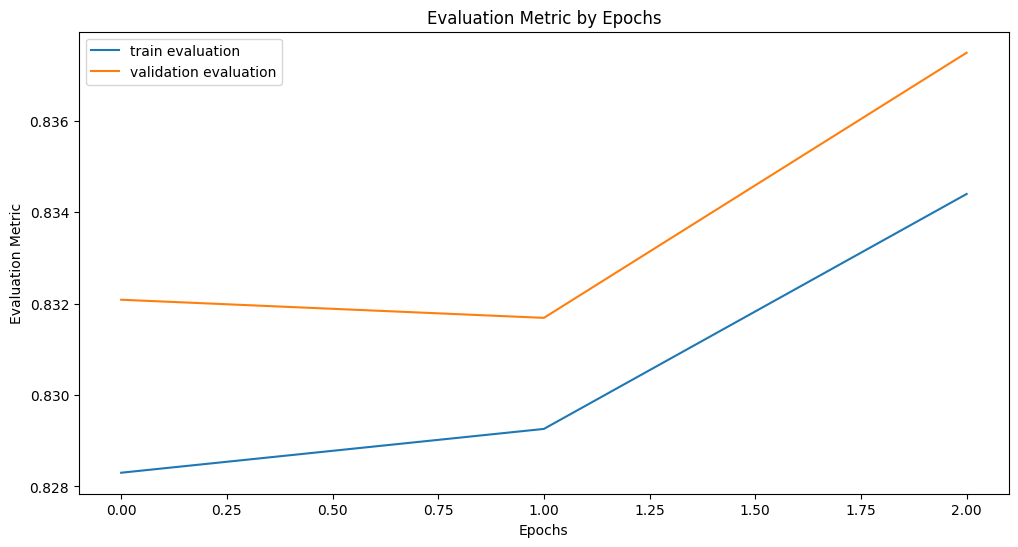

In [6]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [7]:
executor.test(model, test_dataset, evaluator, if_regression = False)

0.8366051953202459

# just load a trained model and see the result

In [8]:
# # load data
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
# df = utils.load_data(path)

# # load torch model
# import torch
# model = torch.load(Path("..") / "trained_models" / "model.pth")

# # split data
# train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# X_test, y_test = test_dataset.tensors

# # test the model
# model.eval()
# outputs = model(X_test)
# y_pred = outputs.squeeze()

# # get the l1 distance between the predicted and actual values
# loss = torch.nn.L1Loss()
# loss(y_pred, y_test)

Loaded the dataset with 118 features and 3064705 curves..


c:\Users\Xiaoyu Huang\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([20172])) that is different to the input size (torch.Size([20172, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (20172) at non-singleton dimension 1